In [9]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [10]:
import numpy as np
from core.metrics import pmse
from core.linalg_utils import circular_aperture, random_unitary_matrix
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
n = 256
m = int(3*n)
shape = (m,)
rng = np.random.default_rng(seed=123)
var = 1e-4
U = random_unitary_matrix(m, rng=rng)

# Support mask: center half active
support = np.zeros(shape, dtype=bool)
support[n:2*n] = True

# ==== 2. グラフ定義 ====
class SimplePhaseGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = SupportPrior(support=support)
        self.Y = UnitaryPropagator(U) @ self.X
        self.Z = AmplitudeMeasurement(var=var, damping=0.1) @ self.Y
        self.compile()

# ==== 3. 初期化とデータ生成 ====
g = SimplePhaseGraph()
g.set_init_rng(np.random.default_rng(seed=11))

g.generate_sample(rng=np.random.default_rng(seed=999), update_observed = True)
true_x = g.X.get_sample()

# ==== 4. 推論（Belief Propagation） ====
def monitor(graph, t):
    if t % 20 == 0:
        est = graph.X.compute_belief().data
        err = pmse(est, true_x)
        print(f"[t={t}] PMSE = {err:.3e}")

g.run(n_iter=100, callback=monitor)

# ==== 5. 結果 ====
final_est = g.X.compute_belief().data
final_err = pmse(final_est, true_x)
print(f"\nFinal PMSE after 100 iterations: {final_err:.3e}")

BP Iteration: 100%|██████████| 100/100 [00:00<00:00, 1453.92it/s]

[t=0] PMSE = 7.012e-01
[t=20] PMSE = 3.239e-01
[t=40] PMSE = 9.617e-03
[t=60] PMSE = 2.529e-04
[t=80] PMSE = 2.516e-04

Final PMSE after 100 iterations: 2.516e-04


In [11]:
%prun -l 40 -s cumulative g.run(n_iter=100, callback=monitor)

BP Iteration: 100%|██████████| 100/100 [00:00<00:00, 1447.14it/s]

[t=0] PMSE = 2.516e-04
[t=20] PMSE = 2.516e-04
[t=40] PMSE = 2.516e-04
[t=60] PMSE = 2.516e-04
[t=80] PMSE = 2.516e-04
 

         20954 function calls in 0.066 seconds

   Ordered by: cumulative time
   List reduced from 196 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.066    0.066 {built-in method builtins.exec}
        1    0.000    0.000    0.066    0.066 <string>:1(<module>)
        1    0.000    0.000    0.066    0.066 graph.py:136(run)
      100    0.000    0.000    0.061    0.001 graph.py:131(backward)
      100    0.000    0.000    0.051    0.001 unitary_propagator.py:109(backward)
      100    0.044    0.000    0.048    0.000 unitary_propagator.py:60(compute_belief)
      100    0.000    0.000    0.009    0.000 base.py:129(backward)
      100    0.000    0.000    0.008    0.000 amplitude_measurement.py:84(_compute_message)
      100    0.002    0.000    0.006    0.000 amplitude_measurement.py:59(approximate_posterior)
      200    0.002    0.000    0.005    0.000 linalg_utils.py:4(reduce_precision_to_scala

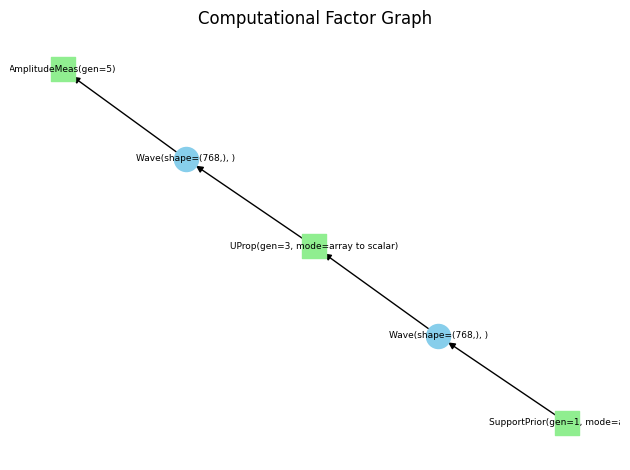

In [12]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

## Fourier Phase Retrieval

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from core.metrics import pmse
from core.linalg_utils import circular_aperture, random_phase_mask
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
support_radius = 0.2
rng = np.random.default_rng(seed=42)
support = circular_aperture(shape, radius=support_radius)

class StructuredRandomGraph(Graph):
    def __init__(self, n_layers=1):
        super().__init__()
        # Support Prior
        x = SupportPrior(support=support, label = "object")
        # Random Structured Matrix
        for i in range(n_layers):
            phase = random_phase_mask(shape, rng=rng)
            x = FFT2DPropagator() @ (PhaseMaskPropagator(phase) @ x)
        # Amplitude Measurement
        self.Z = AmplitudeMeasurement(var=var, damping=0.3) @ x
        self.compile()

# ==== 4. 初期化と推論 ====
g = StructuredRandomGraph(n_layers=3)
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)
X = g.get_wave("object")
true_x = X.get_sample()

def monitor(graph, t):
    X = graph.get_wave("object")
    est = X.compute_belief().data
    err = pmse(est, true_x)
    if t % 50 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=300, callback=monitor, verbose = False)

[t=0] PMSE = 2.44014e-01
[t=50] PMSE = 3.84025e-03
[t=100] PMSE = 6.84705e-05
[t=150] PMSE = 6.07451e-05
[t=200] PMSE = 6.07232e-05
[t=250] PMSE = 6.07236e-05


In [18]:
%prun -l 40 -s cumulative g.run(n_iter=100, callback=None)

BP Iteration: 100%|██████████| 100/100 [00:00<00:00, 338.77it/s]

         87292 function calls in 0.298 seconds

   Ordered by: cumulative time
   List reduced from 221 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.298    0.298 {built-in method builtins.exec}
        1    0.000    0.000    0.297    0.297 <string>:1(<module>)
        1    0.000    0.000    0.297    0.297 graph.py:136(run)
      100    0.001    0.000    0.252    0.003 graph.py:131(backward)
      300    0.001    0.000    0.184    0.001 fft_2d_propagator.py:104(backward)
      300    0.022    0.000    0.154    0.001 fft_2d_propagator.py:55(compute_belief)
      600    0.002    0.000    0.097    0.000 _pocketfft.py:701(_raw_fftnd)
     1200    0.002    0.000    0.087    0.000 _pocketfft.py:49(_raw_fft)
     1200    0.083    0.000    0.083    0.000 {built-in method numpy.fft._pocketfft_internal.execute}
      300    0.001    0.000    0.064    0.000 linalg_utils.py:247(ifft2_centered)
      700    0.

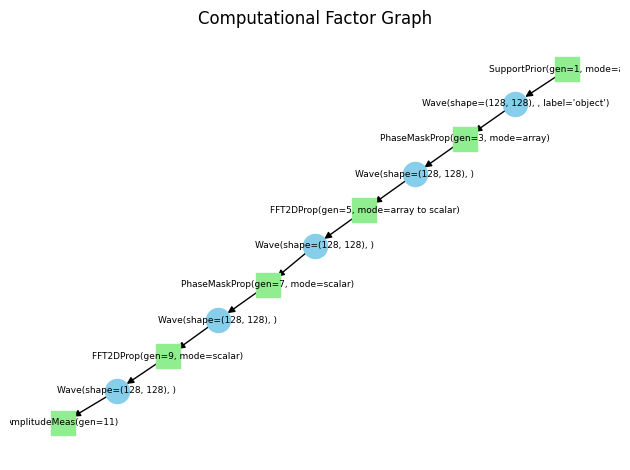

In [15]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)